In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np

import cartopy.crs as ccrs

import xarray as xr

import plotly.offline as py
import numpy as np           
from scipy.io import netcdf  
from mpl_toolkits.basemap import Basemap
import warnings
from numpy import sin, cos, pi
import pandas as pd
import warnings

# Functions

In [92]:
def mapping_map_to_sphere(lon, lat, radius=1):
    #this function maps the points of coords (lon, lat) to points onto the  sphere of radius radius

    lon = np.array(lon, dtype=np.float64)
    lat = np.array(lat, dtype=np.float64)
    lon = degree2radians(lon)
    lat = degree2radians(lat)
    xs = radius * cos(lon) * cos(lat)
    ys = radius * sin(lon) * cos(lat)
    zs = radius * sin(lat)
    return xs, ys, zs


def degree2radians(degree):
    #convert degrees to radians
    return degree * pi / 180


# Functions converting coastline/country polygons to lon/lat traces
def polygons_to_traces(poly_paths, N_poly, m=None):
    ''' 
    pos arg 1. (poly_paths): paths to polygons
    pos arg 2. (N_poly): number of polygon to convert
    '''
    # init. plotting list
    lons = []
    lats = []

    for i_poly in range(N_poly):
        poly_path = poly_paths[i_poly]

        # get the Basemap coordinates of each segment
        coords_cc = np.array([
            (vertex[0], vertex[1])
            for (vertex, code) in poly_path.iter_segments(simplify=False)
        ])

        # convert coordinates to lon/lat by 'inverting' the Basemap projection
        lon_cc, lat_cc = m(coords_cc[:, 0], coords_cc[:, 1], inverse=True)

        lats.extend(lat_cc.tolist() + [None])
        lons.extend(lon_cc.tolist() + [None])

    return lons, lats


# Function generating coastline lon/lat
def get_coastline_traces(m=None):
    poly_paths = m.drawcoastlines().get_paths()  # coastline polygon paths
    N_poly = 91  # use only the 91st biggest coastlines (i.e. no rivers)
    cc_lons, cc_lats = polygons_to_traces(poly_paths, N_poly, m)
    return cc_lons, cc_lats


# Function generating country lon/lat
def get_country_traces(m=None):
    poly_paths = m.drawcountries().get_paths()  # country polygon paths
    N_poly = len(poly_paths)  # use all countries
    country_lons, country_lats = polygons_to_traces(poly_paths, N_poly, m)
    return country_lons, country_lats


# Get list of of coastline, country, and state lon/lat


def make_3D_world(data=None,
                  title="",
                  unit="x",
                  filename=None,
                  country=False,
                  min_val=None,
                  max_val=None, slider = False):
    assert type(slider) is bool, "slider can be assigned only bool values."
    if slider is False:
        # Make shortcut to Basemap object,
        # not specifying projection type for this example
        m = Basemap()

        cc_lons, cc_lats = get_coastline_traces(m=m)
        if country is True:
            country_lons, country_lats = get_country_traces(m=m)
        else:
            country_lons, country_lats = [], []

        #concatenate the lon/lat for coastlines and country boundaries:
        lons = cc_lons + [None] + country_lons
        lats = cc_lats + [None] + country_lats

        xs, ys, zs = mapping_map_to_sphere(lon=lons, lat=lats, radius=1.01)
        # xs, ys, zs=mapping_map_to_sphere(lons, lats, radius=1.01)# here the radius is slightly greater than 1
        #                                                          #to ensure lines visibility; otherwise (with radius=1)
        #                                                          # some lines are hidden by contours colors

        boundaries = dict(type='scatter3d',
                          x=xs,
                          y=ys,
                          z=zs,
                          mode='lines',
                          line=dict(color='black', width=1))

        colorscale = [[0.0, '#313695'], [0.07692307692307693, '#3a67af'],
                      [0.15384615384615385, '#5994c5'],
                      [0.23076923076923078, '#84bbd8'],
                      [0.3076923076923077, '#afdbea'],
                      [0.38461538461538464, '#d8eff5'],
                      [0.46153846153846156, '#d6ffe1'],
                      [0.5384615384615384, '#fef4ac'],
                      [0.6153846153846154, '#fed987'],
                      [0.6923076923076923, '#fdb264'],
                      [0.7692307692307693, '#f78249'],
                      [0.8461538461538461, '#e75435'],
                      [0.9230769230769231, '#cc2727'], [1.0, '#a50026']]

        clons = np.array(list(data.lon), dtype=np.float64)
        clats = np.array(data.lat, dtype=np.float64)
        clons, clats = np.meshgrid(clons, clats)

        XS, YS, ZS = mapping_map_to_sphere(clons, clats)

        nrows, ncolumns = np.array(data).shape
        OLR = np.zeros(clons.shape, dtype=np.float64)
        OLR[:, :ncolumns] = np.copy(np.array(data, dtype=np.float64))
        OLR[:, ncolumns - 1] = np.copy(np.array(data)[:, 0])

        text = [[
            'lon: ' + '{:.2f}'.format(clons[i, j]) + '<br>lat: ' +
            '{:.2f}'.format(clats[i, j]) + '<br>W: ' + '{:.2f}'.format(OLR[i][j])
            for j in range(ncolumns)
        ] for i in range(nrows)]

        if min_val is None:
            min_val = min(np.array(data).ravel())
        if max_val is None:
            max_val = max(np.array(data).ravel())
        sphere = dict(type='surface',
                      x=XS,
                      y=YS,
                      z=ZS,
                      colorscale=colorscale,
                      surfacecolor=OLR,
                      cmin=min_val,
                      cmax=max_val,
                      colorbar=dict(thickness=20, len=0.75, ticklen=4, title=unit),
                      text=text,
                      hoverinfo='text')

        noaxis = dict(showbackground=False,
                      showgrid=False,
                      showline=False,
                      showticklabels=False,
                      ticks='',
                      title='',
                      zeroline=False)

        layout3d = dict(title=title,
                        font=dict(family='Balto', size=14),
                        width=800,
                        height=800,
                        scene=dict(xaxis=noaxis,
                                   yaxis=noaxis,
                                   zaxis=noaxis,
                                   aspectratio=dict(x=1, y=1, z=1),
                                   camera=dict(eye=dict(x=1.15, y=1.15, z=1.15))),
                        paper_bgcolor='rgba(235,235,235, 0.9)')

        fig = dict(data=[sphere, boundaries], layout=layout3d)
        if filename is None:
            # py.sign_in('empet', 'api_key')
            py.iplot(fig, filename='radiation-map2sphere')
        else:
            py.plot(fig, validate=False, filename=filename, auto_open=True)
    else:
        # Make shortcut to Basemap object,
        # not specifying projection type for this example
        m = Basemap()

        cc_lons, cc_lats = get_coastline_traces(m=m)
        if country is True:
            country_lons, country_lats = get_country_traces(m=m)
        else:
            country_lons, country_lats = [], []

        #concatenate the lon/lat for coastlines and country boundaries:
        lons = cc_lons + [None] + country_lons
        lats = cc_lats + [None] + country_lats

        xs, ys, zs = mapping_map_to_sphere(lon=lons, lat=lats, radius=1.01)
        # xs, ys, zs=mapping_map_to_sphere(lons, lats, radius=1.01)# here the radius is slightly greater than 1
        #                                                          #to ensure lines visibility; otherwise (with radius=1)
        #                                                          # some lines are hidden by contours colors

        boundaries = dict(type='scatter3d',
                          x=xs,
                          y=ys,
                          z=zs,
                          mode='lines',
                          line=dict(color='black', width=1))

        colorscale = [[0.0, '#313695'], [0.07692307692307693, '#3a67af'],
                      [0.15384615384615385, '#5994c5'],
                      [0.23076923076923078, '#84bbd8'],
                      [0.3076923076923077, '#afdbea'],
                      [0.38461538461538464, '#d8eff5'],
                      [0.46153846153846156, '#d6ffe1'],
                      [0.5384615384615384, '#fef4ac'],
                      [0.6153846153846154, '#fed987'],
                      [0.6923076923076923, '#fdb264'],
                      [0.7692307692307693, '#f78249'],
                      [0.8461538461538461, '#e75435'],
                      [0.9230769230769231, '#cc2727'], [1.0, '#a50026']]
        
        clons = np.array(list(data.lon), dtype=np.float64)
        clats = np.array(data.lat, dtype=np.float64)
        clons, clats = np.meshgrid(clons, clats)

        XS, YS, ZS = mapping_map_to_sphere(clons, clats)

        nrows, ncolumns = np.array(data).shape[1:3]
        yearly_data = data.groupby("time.year").mean()
        spheres = []
        for i in range(len(yearly_data.year)):
            OLR = np.zeros(clons.shape, dtype=np.float64)
            OLR[:, :ncolumns] = np.copy(np.array(yearly_data[i,:,:], dtype=np.float64))
            OLR[:, ncolumns - 1] = np.copy(np.array(yearly_data[i,:,:])[:, 0])

            text = [[
            'lon: ' + '{:.2f}'.format(clons[i, j]) + '<br>lat: ' +
            '{:.2f}'.format(clats[i, j]) + '<br>W: ' + '{:.2f}'.format(OLR[i][j])
            for j in range(ncolumns)
            ] for i in range(nrows)]

            if min_val is None:
                min_val = min(np.array(data).ravel())
            if max_val is None:
                max_val = max(np.array(data).ravel())
            spheres.append(dict(type='surface',
                        visible = False,
                      x=XS,
                      y=YS,
                      z=ZS,
                      colorscale=colorscale,
                      surfacecolor=OLR,
                      cmin=min_val,
                      cmax=max_val,
                      colorbar=dict(thickness=20, len=0.75, ticklen=4, title=unit),
                      text=text,
                      hoverinfo='text'))

        noaxis = dict(showbackground=False,
                      showgrid=False,
                      showline=False,
                      showticklabels=False,
                      ticks='',
                      title='',
                      zeroline=False)
        
        steps = []
        for i in range(len(spheres)):
            step = dict(
                method = 'restyle',
                label = int(yearly_data.year[i]),
                args = ['visible', [False] * (len(spheres)+1)],
            )
            step['args'][1][i] = True # Toggle i'th trace to "visible"
            step['args'][1][-1] = True # Toggle the costlines
            steps.append(step)
            
        sliders = [dict(
            active = 10,
            currentvalue = {"prefix": "Year: "},
            pad = {"t": len(spheres)},
            steps = steps,
            name = 'Year'
        )]
        spheres[10]['visible'] = True
        layout3d = dict(title=title,
                        sliders=sliders,
                        font=dict(family='Balto', size=14),
                        width=800,
                        height=800,
                        scene=dict(xaxis=noaxis,
                                   yaxis=noaxis,
                                   zaxis=noaxis,
                                   aspectratio=dict(x=1, y=1, z=1),
                                   camera=dict(eye=dict(x=1.15, y=1.15, z=1.15))),
                        paper_bgcolor='rgba(235,235,235, 0.9)')

        fig = dict(data= (spheres+ [boundaries]), layout=layout3d)
        if filename is None:
            # py.sign_in('empet', 'api_key')
            py.iplot(fig, filename='radiation-map2sphere')
        else:
            py.plot(fig, validate=False, filename=filename, auto_open=True)

def get_anomalies(data=None, data_normals=None):
    data_anom = data
    y0 = 0
    for yi in range(0, int(len(data) / 12)):
        data_anom.iloc[y0:y0 + 12] = data.iloc[y0:y0 + 12] - np.array(
            data_normals.iloc[:])
        y0 += 12
    return data_anom


def get_anomalies(ts=None, reference_period=None):
    if reference_period is None:
        warnings.warn("No reference period given. Selecting 1960-1990")
        reference_period = slice("1960-01-01", "1990-12-31")
    return (ts.groupby("time.month") -
            ts.sel(time=reference_period).groupby('time.month').mean("time"))

# Description

The objective of this assignment is to plot (and possibly evaluate) the difference in Surface Temperature between the first 50 and the last 50 years of the XXth century. Theperiod 1960 - 1990 is taken as **reference period**, and **anomalies** are calculate on it.

# Code

In [3]:
# Load the chosen dataset.
# This code might be implemented better
# if access to a yaml file were given.
datapaths = [
    "./data/ts_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc"
    #     ,"ts_Amon_MRI-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc"
]
ts_datasets = {file.split("_")[2]: xr.open_dataset(file) for file in datapaths}

## Model Preview

In [4]:
plt.figure(figsize=(0.001, 0.001))
for name, data in ts_datasets.items():
    # Traslate the longitudes from 0:360 to -180:180
    data.coords['lon'] = (data.coords['lon'] + 180) % 360 - 180
    data = data.sortby(data.lon)
    # Add the longitude 180, since it is missing from the dataset
    data = data.ts.mean(axis=0) - 273.15
    data = data.interp(lat=data.lat,
                       lon=list(data.lon) + [180],
                       method='nearest',
                       kwargs={"fill_value": "extrapolate"})
    make_3D_world(data=data,
                  min_val=-40,
                  max_val=40,
                  title="Average Surface Temperature (1850-2014), [model: " +
                  str(name) + "]",
                  unit="ºC",
                  filename="./output/" + str(name) + "_avg_ts_1850-2014.html")

## Model Anomalies

In [5]:
anomalies = {
    name: get_anomalies(ts=data.ts, reference_period = slice("1850", "1900"))
    for name, data in ts_datasets.items()
}

In [6]:
slices = [slice("1900-01-01", "1950-12-31"), slice("1950-01-01", "2000-12-31"), slice("2000-12-31", "2014-12-31")]
plt.figure(figsize=(0.1, 0.1))
all_anoms = []
for name, anom in anomalies.items():
    for sl in slices:
        anom_sl = anom.sel(time=sl)
        # Traslate the longitudes from 0:360 to -180:180
        anom_sl.coords['lon'] = (anom_sl.coords['lon'] + 180) % 360 - 180
        anom_sl = anom_sl.sortby(anom.lon)
        # Add the longitude 180, since it is missing from the dataset

        anom_sl = anom_sl.interp(lat=anom_sl.lat,
                                 lon=list(anom_sl.lon) + [180],
                                 method='nearest',
                                 kwargs={"fill_value": "extrapolate"})
        #         make 3d plot
# Unfortunately, there is no easy way to remove the plot of the costlines
        make_3D_world(data=anom_sl.mean("time"),
                      title="Average Anomaly " + str(sl) + ", [model: " +
                      str(name) + "]",
                      unit="ºC",
                      min_val = -4,
                      max_val = 4,
                      filename="./output/" + str(name) + "_anom_ts_" +
                      str(sl) + ".html")
        all_anoms.append(anom_sl.mean("time"))

In [10]:
plt.figure(figsize = (0.001, 0.001))
make_3D_world(data=all_anoms[0] - all_anoms[1],
                      title="Difference in Average Anomalies between first 2 selected periods [model: " +
                      str(name) + "]",
                      unit="ºC",
                      min_val = -4,
                      max_val = 4,
                      filename="./output/" + str(name) + "_diff_anom_.html")

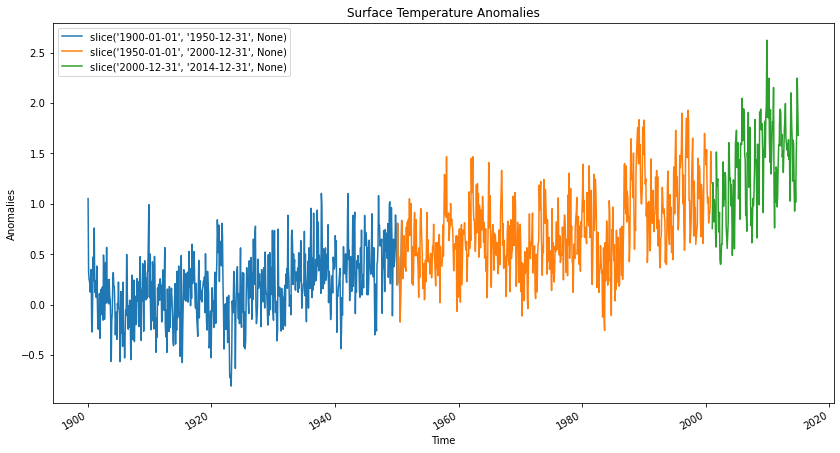

In [8]:
plt.figure(figsize=(14, 7))
for name, anom in anomalies.items():
    for sl in slices:
        anom_sl = anom.sel(time=sl)
        # Traslate the longitudes from 0:360 to -180:180
#         anom_sl.coords['lon'] = (anom_sl.coords['lon'] + 180) % 360 - 180
#         anom_sl = anom_sl.sortby(anom.lon)
        # Add the longitude 180, since it is missing from the dataset

#         anom_sl = anom_sl.interp(lat=anom_sl.lat,
#                                  lon=list(anom_sl.lon) + [180],
#                                  method='nearest',
#                                  kwargs={"fill_value": "extrapolate"})
        #         make timeseries
        anom_ts = anom_sl.mean(['lon', 'lat'])
        anom_ts.plot(label = str(sl))
    plt.title("Surface Temperature Anomalies")
    plt.legend(loc = 'best')
    plt.xlabel("Time")
    plt.ylabel("Anomalies")
    plt.savefig("./output/"+str(name)+"+anom_ts_time.pdf")
    plt.show()

# Extra

In [95]:
plt.figure(figsize=(0.01, 0.01))
for name, anom in anomalies.items():
    # Traslate the longitudes from 0:360 to -180:180
    anom.coords['lon'] = (anom.coords['lon'] + 180) % 360 - 180
    anom = anom.sortby(anom.lon)
    # Add the longitude 180, since it is missing from the dataset

    anom = anom.interp(lat=anom.lat,
                       lon=list(anom.lon) + [180],
                       method='nearest',
                       kwargs={"fill_value": "extrapolate"})
    #         make 3d plot
    # Unfortunately, there is no easy way to remove the plot of the costlines
    make_3D_world(
        data=anom,
        title="Average Anomaly over the years [model: " + str(name) + "]",
        unit="ºC",
        min_val=-4,
        max_val=4,
        slider=True,
        filename="./output/" + str(name) + "_slider_anom" + str(sl) + ".html")